In [ ]:
import pandas as pd

data = pd.read_csv("no_nulls_1.csv")
data.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)
data.shape

In [ ]:
nunique_40 = data.nunique(axis=0) > 70
nunique_40 = nunique_40[nunique_40]
nunique_40[['longitude', 'latitude', 'time', '1st_road_number', '2nd_road_number']] = False
nunique_40 = nunique_40[nunique_40]
std_dev = data[nunique_40.index].std(axis=0)

In [ ]:
data.head()[['engine_capacity_(cc)', 'age_of_vehicle']]
data.dropna(inplace=True)

data.shape

In [ ]:
mu = data[std_dev.index].mean()
k = 3

for index, row in data.iterrows():
    r = row.loc[std_dev.index]
    old_len = r.shape[0]
    r = r[(mu - k*std_dev < r) & (r < mu + k*std_dev)]
    new_len = r.shape[0]
    if new_len != old_len:
        data.drop(index, inplace=True)
    
data.shape

In [ ]:
import pickle
pickle.dump(data, open("data_post_std.pickle", 'wb'))

In [ ]:
data = pickle.load(open("data_post_std.pickle", 'rb'))

In [ ]:
feature_list = [ 'longitude',
 'latitude',
 'police_force',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'day_of_week',
 'time', '1st_road_class',
 '1st_road_number',
 'road_type',
 'speed_limit','junction_detail',
 'junction_control',
 '2nd_road_class',
 '2nd_road_number', 'pedestrian_crossing-human_control',
 'pedestrian_crossing-physical_facilities',
 'light_conditions',  'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'carriageway_hazards',
 'urban_or_rural_area','did_police_officer_attend_scene_of_accident', 
 'casualty_class']
data = data[feature_list]

In [ ]:
y = data['casualty_class']
X = data.drop('casualty_class', axis=1)

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X.values)

In [ ]:
from sklearn.decomposition import IncrementalPCA
import numpy as np

n_batches = 5

explained_variances = []

def fit_PCA(n_components, X):
    inc_pca = IncrementalPCA(n_components=n_components)
    
    for X_batch in np.array_split(X, n_batches):
        inc_pca.partial_fit(X_batch)
        
    return inc_pca    

for n_components in range(1, 25, 1):
    inc_pca = fit_PCA(n_components, X)
    X_reduced = inc_pca.transform(X)
    cumsum = np.cumsum(inc_pca.explained_variance_ratio_)
    explained_variances.append(np.max(cumsum))
    # Calculating the number of the dimensions we need until we get 95% explained variance 
    # We then want the next one up.
    d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(y=0.95, linestyle='--', color="black")
ax.axvline(x=21, linestyle='--', color="black")
ax.plot(explained_variances)
ax.set_xlabel("Dimension")
ax.set_ylabel("Explained Variance")

In [ ]:
inc_pca = fit_PCA(21, X)
X_reduced = inc_pca.transform(X)
X_reduced.shape

In [ ]:
pickle.dump((X_reduced, y), open("./X_reduced_test.pickle", "wb"))

In [1]:
import pickle
X_reduced, y = pickle.load(open("./X_reduced_test.pickle", 'rb'))

In [2]:
# Need to set casualty severity to start from 0
y_labels = y.apply(lambda x : x - 1)

## Creating neural network to classify accident severity

In [3]:
import tensorflow as tf
n_inputs = X_reduced.shape[1]
n_hidden1 = 128
n_hidden2 = 32
n_outputs = 3

/home/vinulw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [5]:
dropout_rate = 0.9

training = tf.placeholder_with_default(False, shape=(), name="training")

X_drop = tf.layers.dropout(X, dropout_rate, training=training)


with tf.name_scope("NN"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [6]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [7]:
eta = 0.0005
m = 0.7

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(eta, momentum=m, use_nesterov=True)
    training_op = optimizer.minimize(loss)

In [8]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [9]:
init = tf.global_variables_initializer()

In [10]:
from sklearn.model_selection import train_test_split

epochs = 30
batch_size = 50

with tf.Session() as sess:
    init.run()
    
    losses = []
    accuracies_val = []
    accuracies_training = []

    for epoch in range(epochs):
        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_labels, random_state=4, test_size=0.3)
        size = X_train.shape[0]
        for i in range(size // batch_size):
            split_slice = slice(i, min(size, i+batch_size), 1)
            X_train_batch = X_train[split_slice]
            y_train_batch = y_train[split_slice]
            sess.run(training_op, feed_dict={X: X_train_batch, y: y_train_batch})
        acc_train = accuracy.eval(feed_dict={X: X_train_batch, y: y_train_batch})
        acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        l = sess.run(loss, feed_dict={X: X_test, y: y_test})
        losses.append(l)
        accuracies_val.append(acc_val)
        accuracies_training.append(acc_train)

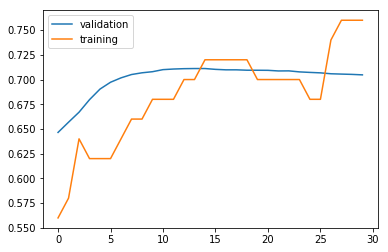

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(accuracies_val, label="validation")
plt.plot(accuracies_training, label="training")
plt.legend()

## Import the Test Data

In [ ]:
test_file = ""